In [1]:
#@title Import & pip
%%capture
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from google.colab import drive
drive.mount('./MyDrive')
# 경로는 "/content/drive/MyDrive/~~"
!pip install -U --no-cache-dir pymoo
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.algorithms.soo.nonconvex.ga  import GA
from pymoo.core.problem import Problem
from pymoo.util.termination.f_tol import MultiObjectiveSpaceToleranceTermination
from pymoo.util.termination.x_tol import DesignSpaceToleranceTermination
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter
from pymoo.factory import get_sampling, get_crossover, get_mutation
from pymoo.util.display import Display
from pymoo.operators.mixed_variable_operator import MixedVariableSampling, MixedVariableMutation, MixedVariableCrossover
from pymoo.core.problem import ElementwiseProblem
!pip install pykrige
!pip install tqdm
from tqdm import tqdm, trange
!pip install pyDOE
import time
import scipy.stats
import copy
import pickle 

# ! pip install import_ipynb
# import import_ipynb
# import Regression HK_class.ipynb

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fexperimentsandconfigs%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:
4/1AX4XfWhHErIbiNmFmiP2DTXXEDEsZ4nPZlH4X1fkZyFd8tXyte6U2v3zWSQ


In [8]:
## @title HK class
class HK:

  ###################################
  def __init__(self, x, y, pop, gen, HKtype = "r"):
    self.t_start = time.time()
    self.x, self.y = x, y
    self.pop, self.gen = pop, gen
    self.total_level = len(x)
    self.current_level = 0
    self.HKtype = HKtype # Regression: "r" & Interpolation: "i"
    
    if self.HKtype == "i":
      self.total_opt_theta, self.total_R, self.total_invR, self.total_F, self.total_beta, self.total_sigmaSQ, self.total_MLE = [], [], [], [], [], [], []
    elif self.HKtype == "r":
      self.total_opt_theta, self.total_opt_nugget, self.total_opt_order, self.total_R, self.total_invR, self.total_F, self.total_beta, self.total_sigmaSQ, self.total_MLE = [], [], [], [], [], [], [], [], []
    else:
      print("Invalid HK type")
     
  ###################################
  def train(self, ann=False, to_level = None, Penalize = False):
    self.penal = Penalize
    if to_level == None: # to_level 입력안되면 모든 fidelity 학습
      to_level = self.total_level-1
    
    while self.current_level < to_level + 1 :
      if ann == True:
        print("#########  Level %d starts  #########" % (self.current_level))
      t_temp = time.time()
      x, y = self.x[self.current_level], self.y[self.current_level]
      self.opt_bef_action()
      self.GA_results = self.GA_krig(self.current_level)
      self.opt_X = self.GA_results[0]
      self.opt_aft_action(x,y,self.opt_X)
      
      announce = "   Final generation = %s" % (self.GA_results[2])
      announce += "\n   Optimal theta = %s" % (self.total_opt_theta[self.current_level])
      if self.HKtype == "r":
        announce += "\n   Optimal nugget = %E" % (self.total_opt_nugget[self.current_level])
      announce += "\n   Optimal likelihood = %f" % (self.total_MLE[self.current_level])
      announce += "\n   Optimal R's condition number = %f" % (np.linalg.cond(self.total_R[self.current_level]))
      announce += "\n   Level %d finishes with time %f[s]" % (self.current_level, time.time()-t_temp)
      
      if ann == True:
        print(announce)

      self.current_level += 1
    
    if ann == True:
      print("#########  HK total training time = %f[s]  #########\n" % (time.time()-self.t_start))

  
  ###################################
  def opt_bef_action(self): #x,y,current_level,*args): 
    
    self.N_pts = self.x[self.current_level].shape[0]

    if self.current_level == 0 :
      F = np.ones(self.N_pts) 
    else :# if current_level != 0 --> F = estimate으로넣기
      F = self.pred_y_MSE(self.x[self.current_level], self.current_level-1)[0]
    
    self.total_F.append(F)

  ###################################
  def pred_y_MSE(self,x_test,test_level):
    # HF들의 y와 MSE 계산에는 r_vector와 y_pred의 계산만 새로 필요. 나머지는 새로 계산할 필요 없음
    
    N_pts_test = self.x[test_level].shape[0]
    R = self.total_R[test_level]
    invR = self.total_invR[test_level]
    
    if self.HKtype == "i":
      temp_X = self.total_opt_theta[test_level]
    elif self.HKtype == "r":
      temp_X = self.total_opt_theta[test_level]
      temp_X = np.append(temp_X,self.total_opt_nugget[test_level])
          
    r_vector = self.cal_r_vector(x_test,temp_X,test_level)
    F = self.total_F[test_level]
    beta = self.total_beta[test_level]
    sigmaSQ = self.total_sigmaSQ[test_level]
    

    if self.HKtype == "i":
      if test_level == 0 :

        y_pred = beta + r_vector.transpose() @ invR @ ( self.y[test_level] - F * beta)
        MSE = []
        
        for i in range(x_test.shape[0]) :
          MSE.append(sigmaSQ * (1 - r_vector.transpose()[i]@ invR @ r_vector[:,i] + (1 - F.transpose() @ invR @ r_vector[:,i]) ** 2 / (F.transpose() @ invR @ F)))
                    
      else :
        y_lf = self.pred_y_MSE(x_test, test_level-1)[0]
        y_pred = beta * y_lf + r_vector.transpose() @ invR @ ( self.y[test_level] - F * beta)
        
        temp_1 = 1 / (F.transpose() @ invR @ F)
        MSE = []
        
        for i in range(x_test.shape[0]) :
          
          temp_2 = r_vector.transpose()[i]@ invR @ r_vector[:,i]
          temp_3 = r_vector.transpose()[i]@ invR @ F
          
          MSE.append((sigmaSQ * (1 - temp_2 + ( temp_3 - y_lf[i] ) * (temp_1) * (temp_3 - y_lf[i]))))
          
    if self.HKtype == "r":
      # nugget 그냥 빼버리면 inv 계산에서 또 수치에러 발생. 이를 완화위해 trick으로 10**-9 fixed nugget 사용
      regression_invR = np.linalg.inv(R - self.total_opt_nugget[test_level] * np.identity(N_pts_test) + 10**-9 * np.identity(N_pts_test))
      regression_sigmaSQ = self.cal_regression_sigmaSQ(N_pts_test, self.y[test_level], F, beta, R, invR, self.total_opt_nugget[test_level])

      if test_level == 0 :
        
        y_pred = beta + r_vector.transpose() @ invR @ ( self.y[test_level] - F * beta)
        MSE = []
        
        for i in range(x_test.shape[0]) :
          
          MSE.append(regression_sigmaSQ * (1  - r_vector.transpose()[i]@ regression_invR @ r_vector[:,i] + (1 - F.transpose() @ regression_invR @ r_vector[:,i]) ** 2 / (F.transpose() @ regression_invR @ F)))
          
          
      else :
        
        y_lf = self.pred_y_MSE(x_test, test_level-1)[0]
        y_pred = beta * y_lf + r_vector.transpose() @ invR @ ( self.y[test_level] - F * beta)
        
        temp_1 = 1 / (F.transpose() @ regression_invR @ F)
        MSE = []
        
        for i in range(x_test.shape[0]) :
          
          temp_2 = r_vector.transpose()[i]@ regression_invR @ r_vector[:,i]
          temp_3 = r_vector.transpose()[i]@ regression_invR @ F
          
          MSE.append((regression_sigmaSQ * ( 1  - temp_2 + ( temp_3 - y_lf[i] ) * (temp_1) * (temp_3 - y_lf[i]))))
          
    MSE = np.array(MSE)
    MSE[MSE < 0] = 0
    return y_pred, np.sqrt(MSE)

  ###################################
  def opt_aft_action(self,x,y,opt_X):
    
    N_pts = self.x[self.current_level].shape[0]
    R=self.cal_R(x,y,opt_X)
    invR = np.linalg.inv(R)

    F = self.total_F[self.current_level]

    transF = F.transpose() 
    beta = self.cal_beta(self.y[self.current_level], F, invR, transF)
    sigmaSQ = self.cal_sigmaSQ(N_pts, self.y[self.current_level], F, beta, invR)
    MLE = self.cal_MLE(N_pts, sigmaSQ, R)

    if self.HKtype == "i":
      opt_theta = opt_X
          
    if self.HKtype == "r":
      opt_theta = opt_X[:-1]
      opt_nugget = opt_X[-1]
      self.total_opt_nugget.append(opt_nugget)
    
    self.total_opt_theta.append(opt_theta)
    self.total_R.append(R)
    self.total_invR.append(invR)
    self.total_beta.append(beta)
    self.total_sigmaSQ.append(sigmaSQ)
    self.total_MLE.append(MLE)
      
  ###################################
  def cal_r(self, x1, x2, X): 
    
      if self.HKtype == "i":
        theta = X
        
      elif self.HKtype == "r":
        theta = X[:-1]
      
      eps = theta*np.abs(x1-x2)
      for enu,temp in enumerate(eps) :
        if temp <= 0.2 :
          eps[enu] = 1 - 15 * temp**2 + 30 * temp**3
        elif 0.2 < temp < 1 :
          eps[enu] = 1.25 * (1-temp)**3
        else :
          eps[enu] = 0
      return np.prod(eps)
        
  ###################################      
  def cal_r_vector (self, x_test, X, test_level) : # x_test shape : (test 데이터 개수, N_dimension)
      
      r_vector = np.zeros((self.x[test_level].shape[0],x_test.shape[0])) # r_vector shape : ( 해당 레벨에서 실제 샘플 데이터 개수,test 데이터 개수) --> 이렇게해야 추후 식들에서 r의 차원이 맞음

      for enu1, temp1 in enumerate(x_test) :

        r_vector[:,enu1] = np.array([self.cal_r(temp1,temp2,X) for temp2 in self.x[test_level]])
      
      return r_vector

  ###################################  
  def cal_R(self,x,y,X): # x : (N_pts,N_dv)의 shape을 가지는 dv값 array, shape : 1차원으로 N_dv개수만큼 원소있음
      
      N_pts = x.shape[0]
      R = np.zeros((N_pts,N_pts)) 

      for i in range(N_pts) :
          for j in range(i + 1, N_pts):
            R[i, j] = self.cal_r(x[i], x[j], X)
      
      if self.HKtype == "i":
        nugget = 10**-12
      elif self.HKtype == "r":
        nugget = X[-1]
      
      return R + R.transpose() + (1 + nugget) * np.identity(N_pts)

  ###################################  
  def cal_beta(self, Y, F, invR, transF) :

      temp_beta = 1 / ((F @ invR @ transF)) 

      return temp_beta * transF @ invR @ Y

  ###################################  
  def cal_sigmaSQ(self, N_pts, Y, F, beta, invR):
        
      return 1 / N_pts * (Y - F * beta).transpose() @ invR @ (Y - F * beta)

  ###################################  
  def cal_regression_sigmaSQ(self, N_pts, Y, F, beta, R, invR, nugget):
          
      return 1 / N_pts * (Y - F * beta).transpose() @ invR @ ( R - nugget * np.identity(N_pts)) @ invR @ (Y - F * beta)

  ###################################  
  def cal_MLE(self, N_pts, sigmaSQ,R):

      det_R = np.linalg.det(R)

      if det_R == 0 :
        return np.float64(-9999.) # det_R = 0 나오면 MLE가 inf가 나와서 해당 theta가 최적해로 뽑혀버림. 이를 방지위해 
      else : 
        MLE = - (N_pts/2) * np.log(sigmaSQ) - 1 / 2 * np.log(np.linalg.det(R)) # MEDOC version Log-likelihood
        return MLE

  ###################################  
  def cal_PMLE(self, N_pts, sigmaSQ,R, X, beta):

      det_R = np.linalg.det(R)

      if det_R == 0 :
        return np.float64(-9999.) # det_R = 0 나오면 MLE가 inf가 나와서 해당 theta가 최적해로 뽑혀버림. 이를 방지위해 
      else : 
        MLE = - (N_pts/2) * np.log(sigmaSQ) - 1 / 2 * np.log(np.linalg.det(R)) # MEDOC version Log-likelihood
      if self.HKtype == "i":
        theta = X
        
      elif self.HKtype == "r":
        theta = X[:-1]
      # Lasso
      # return MLE  - 1* np.abs(beta) * np.sum(theta)
      # print(MLE, np.abs(beta), theta, (np.sum(np.log10(theta)) - 6))
      # return MLE  - np.abs(beta) * np.sum(theta)
      # print(MLE  , np.abs(beta) * (np.sum(np.log10(theta)) - 6))
      return MLE * (np.abs(beta))**(np.sum(np.log10(theta))+6) - (np.sum(np.log10(theta)) + 0)
      # Ridge
      # return MLE * np.abs(beta) * np.sum((10**(theta))**2)
      # print(MLE, np.abs(beta), theta, np.sum(theta**2))
      # print(MLE  , np.abs(beta) * np.sum(theta**2))
      # return MLE  - 1000* np.abs(beta) * np.sum(theta**2)
  ###################################  
  def plot_var(self,x_test,level,function=None):
    plt.style.use('seaborn-ticks')
    
    total_level = len(self.x)
    y_HK= self.pred_y_MSE(x_test, level)
    col = ['b','r','g']
    for i in range(level+1) :
      # plt.scatter(x[i],y[i],marker = 'o',color='red')
      label_ = "Fidelity-level %d data" % i
      plt.scatter(self.x[i],self.y[i],label=label_,color=col[i])
    if function != None:
      plt.plot(x_test,function(x_test),'r-',label="True function")
    if self.HKtype == "r" and level > 0:
      plt.plot(x_test,y_HK[0],'k-',label = "Regression-based HK")
    elif self.HKtype == "i" and level > 0:
      plt.plot(x_test,y_HK[0],'k-',label = "Interpolation-based HK")
    if self.HKtype == "r" and level == 0:
      plt.plot(x_test,y_HK[0],'k-',label = "Regression-based Kriging")
    elif self.HKtype == "i" and level == 0:
      plt.plot(x_test,y_HK[0],'k-',label = "Interpolation-based Kriging")
    # plt.fill_between(x_test, y_HK[0]-2*y_HK[1], y_HK[0]+2*y_HK[1],
    #               facecolor="red", # The fill color
    #               edgecolor='black',       # The outline color
    #               alpha=0.3,
    #               linestyle='--')          # Transparency of the fill

    plt.legend()
    plt.show()

  ###################################  
  def accuracy_plot(self,x_real,y_real,level):
    y_pred = self.pred_y_MSE(x_real,level)[0]
    limit = np.array([np.min([y_pred, y_real]),np.max([y_pred, y_real])])
    plt.plot(limit,limit,c='k')
    plt.xlabel("Real value", fontsize = 15)
    plt.ylabel("Predicted value", fontsize = 15)
    plt.scatter(y_real,y_pred, color = 'k')
    plt.legend(fontsize = 15)
    plt.show()
    r_squared = self.Rsq(x_real,y_real,level)
    print(f"R_sq: {r_squared:.4f}")
  
  ###################################  
  def pred_arbit_theta(self,x_test,current_level,theta,nugget):
    
    N_pts = self.x[current_level].shape[0]
    R = cal_R(self.x[current_level],theta[current_level],nugget)
    print("cond",current_level,np.linalg.cond(R))
    invR = np.linalg.inv(R)
    r_vector = cal_r_vector(x_test,self.x[current_level],theta[current_level])
    F = self.total_F[current_level]
    transF = F.transpose()
    beta = cal_beta(self.y[current_level],F,invR,transF)
    sigmaSQ = cal_sigmaSQ(N_pts,self.y[current_level],F,beta,invR)
    MLE = cal_MLE(N_pts,sigmaSQ,R)

    if current_level == 0 :

      y = beta + r_vector.transpose() @ invR @ ( self.y[current_level] - F * beta)
      MSE = []
      
      for i in range(x_test.shape[0]) :
        
        MSE.append(sigmaSQ * (1 - r_vector.transpose()[i]@ invR @ r_vector[:,i] + (1 - F.transpose() @ invR @ r_vector[:,i]) ** 2 / (F.transpose() @ invR @ F)))

      MSE = np.array(MSE)
      MSE[MSE < 0] = 0
      return y, np.sqrt((MSE)), MLE

    else :
      y_lf = pred_arbit_theta(x_test,current_level-1,theta,nugget)[0]
      y = beta * y_lf + r_vector.transpose() @ invR @ ( self.y[current_level] - F * beta)
      temp_1 = 1 / (F.transpose() @ invR @ F)
      MSE = []
      for i in range(x_test.shape[0]) :
        
        temp_2 = r_vector.transpose()[i]@ invR @ r_vector[:,i]
        temp_3 = r_vector.transpose()[i]@ invR @ F
        MSE.append((sigmaSQ * ( 1 - temp_2 + ( temp_3 - y_lf[i] ) * (temp_1) * (temp_3 - y_lf[i]))))
      
      MSE = np.array(MSE)
      MSE[MSE < 0] = 0
      return y, np.sqrt((MSE)), MLE
  
  ###################################
  def GA_krig(self,current_level) :
    n_var = self.x[current_level].shape[1]
    pop_size = self.pop[current_level]
    gen_size = self.gen[current_level]
    fixed_gen = 0 # 1이면 무조건 해당 gen_size만큼 GA
    # if fixed_gen == 1 :
    #   gen_size = 300
    # elif fixed_gen == 0:
    #   gen_size = 2000

    # nested class 때문에 아래와 같이 새로 정의
    x, y = self.x[current_level], self.y[current_level]
    HKtype = self.HKtype
    total_F = self.total_F
    penal = self.penal
    
    def GA_cal_kriging(x,y,X,current_level,Penalize):
    
      N_pts = x.shape[0]
      R=self.cal_R(x,y,X)
      invR = np.linalg.inv(R)
      F = total_F[current_level]
      transF = F.transpose() 
      beta = self.cal_beta(y, F, invR, transF)
      sigmaSQ = self.cal_sigmaSQ(N_pts, y, F, beta, invR)
      if Penalize == True and current_level > 0:
        MLE = self.cal_PMLE(N_pts,sigmaSQ,R, X, beta)
      else:
        MLE = self.cal_MLE(N_pts,sigmaSQ,R)
      
        

      return MLE
    
    
    if HKtype == "i" : # Hyper-parameter : theta only

      class MyProblem(ElementwiseProblem):

        def __init__(self):
          super().__init__(n_var=n_var,
                            n_obj=1,
                            n_constr=0,
                            xl=np.array([-6.]*n_var),
                            xu=np.array([3.]*n_var),
                            
                            )

        def _evaluate(self, X, out, *args, **kwargs):
          X = 10**X # theta는 log scale로 최적화
          asdf = GA_cal_kriging(x,y,X,current_level,penal)
          asdf = asdf.astype('float32')
          obj1 = -asdf 
          out["F"] = np.column_stack([obj1])
      class MyDisplay(Display):

        def _do(self, problem, evaluator, algorithm):
            super()._do(problem, evaluator, algorithm)
            
      problem = MyProblem()

      algorithm = GA(pop_size=pop_size,
                        mutation=get_mutation("real_pm", prob=0.2),
                        eliminate_duplicates=True
                        )

      if fixed_gen == 1 :

        res = minimize(problem,
                      algorithm,
                      ("n_gen", gen_size),
                      #  verbose=True,
                      #  disply = MyDisplay()

                      )
      elif fixed_gen == 0 :
        termination = DesignSpaceToleranceTermination(tol=10**-4, n_last=40)
        res = minimize(problem,
                      algorithm,
                      termination,
                      ("n_gen", gen_size),
                      #  verbose=True,
                      #  disply = MyDisplay()

                      )
      
      opt = res.X
      opt = 10**opt    
      # res.algorithm.pop : 마지막 population임 추후 initialization에 사용 가능
      return opt, res.F, res.algorithm.n_gen
    
    elif HKtype == "r": # Hyper-parameter : theta, nugget
      class MyProblem(ElementwiseProblem):

        def __init__(self):
          super().__init__(n_var=n_var+1, # nugget과 order를 추가로 고려하기에 +2
                            n_obj=1,
                            n_constr=0,
                            xl=np.array([-6.]*n_var + [-12.]), # cubit spline --> 변수개수 + nugget 
                            xu=np.array([3.]*n_var + [0.]),

                            )

        def _evaluate(self, X, out, *args, **kwargs):
          
          X = 10**X # theta랑 nugget은 log scale로 최적화
          asdf = GA_cal_kriging(x,y,X,current_level,penal)
          asdf = asdf.astype('float32')
          obj1 = -asdf 
          out["F"] = np.column_stack([obj1])
      class MyDisplay(Display):

        def _do(self, problem, evaluator, algorithm):
            super()._do(problem, evaluator, algorithm)

      problem = MyProblem()

      algorithm = GA(pop_size=pop_size,
                        mutation=get_mutation("real_pm", prob=0.2),
                        eliminate_duplicates=True
                        )

      if fixed_gen == 1 :

        res = minimize(problem,
                      algorithm,
                      ("n_gen", gen_size),
                      #  verbose=True,
                      #  disply = MyDisplay()

                      )
      elif fixed_gen == 0 :
        termination = DesignSpaceToleranceTermination(tol=10**-4, n_last=40)
        res = minimize(problem,
                      algorithm,
                      termination,
                      ("n_gen", gen_size),
                      #  verbose=True,
                      #  disply = MyDisplay()

                      )
      
      opt = res.X
      opt = 10**opt
      return opt, res.F, res.algorithm.n_gen

  ###################################
  def opt_on_surrogate(self,xl,xu,pop,gen,current_level,VALorEI,morM="M") :
    # morM : y값을 최소화면 "m" 최대화면 "M"
    # VALorEI : 함수값 최적화면 "VAL" EI 최적화면 "EI" VFEI 최적화면 "VFEI"
    n_var = self.x[current_level].shape[1]
    pop_size = pop
    gen_size = gen
    total_level = self.total_level
    if VALorEI == "VFEI": # 변수 하나 늘려야됨: fidelity level
      xl=np.append(xl,0)
      xu=np.append(xu,total_level-1)
      n_var += 1
      


    # nested class 때문에 아래와 같이 외부의 함수를 부르는 함수 생성
    def opt_pred_y_MSE(x_test,test_level):
      return self.pred_y_MSE(x_test,test_level)
    def opt_cal_EI(x_test,current_level,morM):
      return self.cal_EI(x_test,current_level,morM)
    def opt_cal_VFEI(x_test,current_level,morM):
      return self.cal_VFEI(x_test,current_level,morM)

    class MyProblem(ElementwiseProblem):

      def __init__(self):
        if VALorEI != "VFEI": #VFEI가 아닐 때
          super().__init__(n_var=n_var,
                            n_obj=1,
                            n_constr=0,
                            xl=xl,
                            xu=xu,
                            
                            )
        else: #VFEI는 level까지 최적화 변수에 포함되어 특별한 처리가 필요 "https://pymoo.org/customization/mixed_variable_problem.html"
          super().__init__(n_var=n_var, # 마지막 변수는 fidelity level
                            n_obj=1,
                            n_constr=0,
                            xl=xl,
                            xu=xu,
                            
                            )
      
      def _evaluate(self, X, out, *args, **kwargs):
        X = np.array([X])

        if VALorEI == "VAL" and morM == "m":
          asdf = opt_pred_y_MSE(X,current_level)[0]
          
        elif VALorEI == "VAL" and morM == "M":
          asdf = -opt_pred_y_MSE(X,current_level)[0]
          
        elif VALorEI == "EI": #EI는 항상 maximize
          asdf = -opt_cal_EI(X,current_level,morM)
          
        elif VALorEI == "VFEI": #VFEI는 항상 maximize
          asdf = -opt_cal_VFEI(X[0,:-1],X[0,-1],morM)
          
        obj1 = asdf.astype('float32')
        out["F"] = np.column_stack([obj1])
    
    problem = MyProblem()

    if VALorEI != "VFEI": #VFEI가 아닐 때
      algorithm = GA(pop_size=pop_size,
                        mutation=get_mutation("real_pm", prob=0.2),
                        eliminate_duplicates=True
                        )
      
    else: #VFEI는 level까지 최적화 변수에 포함되어 특별한 처리가 필요 "https://pymoo.org/customization/mixed_variable_problem.html"
      mask = ["real"]*(n_var-1) + ["int"] # n_var 개수만큼의 real dv와 1개의 int dv (fidelity level)
      
      sampling = MixedVariableSampling(mask, {
      "real": get_sampling("real_random"),
      "int": get_sampling("int_random")
      })
      
      crossover = MixedVariableCrossover(mask, {
      "real": get_crossover("real_sbx", prob=1.0, eta=3.0),
      "int": get_crossover("int_sbx", prob=1.0, eta=3.0)
      })

      mutation = MixedVariableMutation(mask, {
      "real": get_mutation("real_pm", eta=3.0),
      "int": get_mutation("int_pm", eta=3.0)
      })

      algorithm = GA(pop_size=pop_size,
                        sampling = sampling,
                        crossover = crossover,
                        mutation = mutation,
                        # mutation=get_mutation("real_pm", prob=0.2),
                        eliminate_duplicates=True
                        )
    if VALorEI != "VFEI": #VFEI가 아닐 때
      termination = DesignSpaceToleranceTermination(tol=10**-4, n_last=40)
    
      res = minimize(problem,
                    algorithm,
                    termination,
                    ("n_gen", gen_size)
                    #  verbose=True,
                    )            
    else:
      res = minimize(problem,
                  algorithm,
                  ("n_gen", gen_size)
                  #  verbose=True,
                
                  )
                  
    opt = res.X

    
    if VALorEI == "VAL" and morM == "m":
      return opt, res.F
    elif VALorEI == "VAL" and morM == "M":
      return opt, -res.F
    elif VALorEI == "EI" :
      return opt, -res.F
    elif VALorEI == "VFEI":
      return opt[-1], opt[:-1], -res.F # opt fidelity level, opt dv, opt value
    
  ###################################
  def cal_EI(self,x_test,current_level,morM):
    # morM : 함수를 최소화면 "m" 최대화면 "M"
    x_test = x_test.reshape(-1,self.x[current_level].shape[1])
    def I(x_test,current_level,morM):
      if morM == "m":
        return np.min(self.y[current_level]) - self.pred_y_MSE(x_test,current_level)[0] # ymin - ypred
      elif morM == "M":
        return self.pred_y_MSE(x_test,current_level)[0] - np.max(self.y[current_level]) # ypred - ymax
    
    I = I(x_test,current_level,morM)
    s = self.pred_y_MSE(x_test,current_level)[1]
    EI = np.zeros(1)

    for enu, x in enumerate(s): # s > 0
      if x > 0 :
        EI[enu] =  I[enu] * scipy.stats.norm.cdf(I[enu]/s[enu]) + s[enu] * scipy.stats.norm.pdf(I[enu]/s[enu])

    return EI
  
  ###################################
  def cal_VFEI(self,x_test,current_level,morM):
    # morM : 함수를 최소화면 "m" 최대화면 "M"
    # level과 dv를 동시에 고려한 최적화가 필요한데 이때 아래 참고
    # https://pymoo.org/customization/mixed_variable_problem.html
    x_test = x_test.reshape(-1,self.x[current_level].shape[1])
    def I(x_test,current_level,morM):
      if morM == "m":
        return np.min(self.y[current_level]) - self.pred_y_MSE(x_test,current_level)[0] # ymin - ypred
      elif morM == "M":
        return self.pred_y_MSE(x_test,current_level)[0] - np.max(self.y[current_level]) # ypred - ymax
    
    I = I(x_test,self.total_level-1,morM) # VF_EI는 Highest-fidelity 기준이여서 self.total_level-1을 넣어야
    s = self.pred_y_MSE(x_test,current_level)[1]

    for level in range(self.total_level - current_level - 1):
      s *= self.total_beta[-level-1-1]
    
    s = np.sqrt(np.square(s))
    EI = np.zeros(1)

    for enu, x in enumerate(s): # s > 0
      if x > 0 :
        EI[enu] =  I[enu] * scipy.stats.norm.cdf(I[enu]/s[enu]) + s[enu] * scipy.stats.norm.pdf(I[enu]/s[enu])
    
    return EI

  ###################################
  def Rsq(self, x, y_real, level):
    y_pred = self.pred_y_MSE(x,level)[0]
    correlation_matrix = np.corrcoef(y_pred, y_real)
    correlation_xy = correlation_matrix[0,1]
    return correlation_xy**2

  ###################################
  def RMSE(self, x, y_real, level):
    y_pred = self.pred_y_MSE(x,level)[0]
    ans = np.sqrt( (np.sum( (y_pred - y_real) ** 2)) / y_real.shape[0])
    return ans

  ###################################
  def MAE(self, x, y_real, level):
    y_pred = self.pred_y_MSE(x,level)[0]
    ans = np.sum( np.abs(y_pred - y_real)) / y_real.shape[0]
    return ans

  ###################################
  def NRMSE(self, x, y_real, level, Type=1):
    #Type = 1(mean), 2(minmax), 3(std), 4(q)
    if Type == 1:
      return self.RMSE(x,y_real,level) / np.mean(y_real)
    elif Type == 2:
      return self.RMSE(x,y_real,level) / ( np.max(y_real) - np.min(y_real) )
    elif Type == 3:
      return self.RMSE(x,y_real,level) / np.std(y_real)
    elif Type == 4:
      return self.RMSE(x,y_real,level) / ( np.percentile(y_real,[75]) - np.percentile(y_real,[25]) )[0]

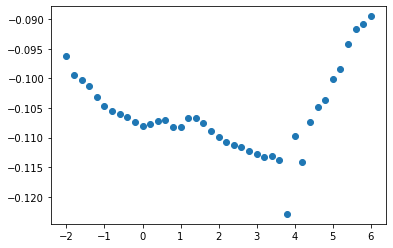

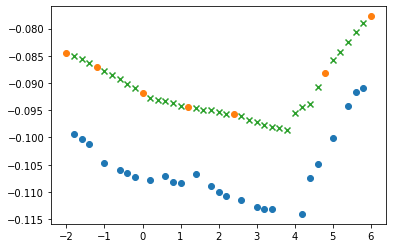

(26, 1) (7, 1) (34,)


In [5]:
# hf_test=np.load("coeff_hf100.npy")
AoA_start, AoA_end = -2, 6
x = np.linspace(AoA_start, AoA_end,41)
hf=np.load("./MyDrive/MyDrive/Colab Notebooks/data fusion/RHK_thesis/kflow_hf.npy")
lf=np.load("./MyDrive/MyDrive/Colab Notebooks/data fusion/RHK_thesis/kflow_lf.npy")
plt.scatter(np.linspace(AoA_start, AoA_end,41),lf[:,2])
plt.show()
# print(hf.shape)


# HF는 3개 징검다리로 skip
# hf = np.delete(hf,[-1,-2],0) # aoa 16.5과 16은 HF cd 값이 너무 극단적으로증가해서 제외
temp_idx = [6*i+4 for i in range(7)]
# temp_idx.remove(4)
# temp_idx.remove(16)
temp_idx.remove(28)
if not 0 in temp_idx:
  train_idx = [0] + temp_idx
if not 40 in temp_idx:
  train_idx = [40] + temp_idx
# train_idx = [0] + temp_idx + [40] # [29] 값이 outlier니까 포함하게끔 조정하기

total_idx_temp = [i for i in range(hf.shape[0])] 
vali_idx = list(set(total_idx_temp) - set(train_idx))

hf_vali = hf[vali_idx]
hf_x_vali = x[vali_idx]
hf = hf[train_idx]
hf_x = x[train_idx]

# 점 개수 너무 많아서 하나씩 skip
# del_idx = [3*i+2 for i in range(int(lf.shape[0]/3)+0)]
# lf = np.delete(lf,del_idx,0) 
# lf_x = np.delete(x,del_idx,0)
# lf_idx = [4*i+0 for i in range(11)] +  [4*i+2 for i in range(10)] + [4*i+3 for i in range(10)] #+ [7*i+4 for i in range(6)] + [7*i+5 for i in range(6)] + [7*i+6 for i in range(5)]
# lf_idx.remove(0) # 시작점 제외 (aoa -2)
# lf_idx.remove(40) # 끝점 제외 (aoa 6)
# lf_idx.append(1)
# lf_idx.remove(29) # 얘 값은 너무 튐 (aoa 3.8)
# lf_idx = list(set(total_idx_temp) - set(temp_idx))
lf_idx = [6*i+1 for i in range(7)] + [6*i+2 for i in range(7)] + [6*i+3 for i in range(7)] +  [6*i+5 for i in range(6)]
# lf_idx = [6*i+1 for i in range(7)] + [6*i+3 for i in range(7)] +  [6*i+5 for i in range(6)]
# lf_idx.append(1)
# lf_idx.append(38)
try:
  lf_idx.remove(29)
except:
  pass
try:
  lf_idx.remove(0)
except:
  pass
try:
  lf_idx.remove(40)
except:
  pass


lf = lf[lf_idx]
lf_x = x[lf_idx]

hf_cl = hf[:,0] 
hf_cd = hf[:,1] 
hf_cm = hf[:,2] 

vali_cl = hf_vali[:,0] 
vali_cd = hf_vali[:,1] 
vali_cm = hf_vali[:,2] 

lf_cl = lf[:,0] 
lf_cd = lf[:,1] 
lf_cm = lf[:,2] 

lf_x = np.reshape(lf_x,(-1,1))
hf_x = np.reshape(hf_x,(-1,1))

plt.scatter(lf_x,lf_cm)
plt.scatter(hf_x,hf_cm)
plt.scatter(hf_x_vali,vali_cm,marker='x')
plt.show()
print(lf_x.shape, hf_x.shape, hf_x_vali.shape)
# print(np.sort(lf_x[:,0]))
# print(np.sort(hf_x[:,0]))


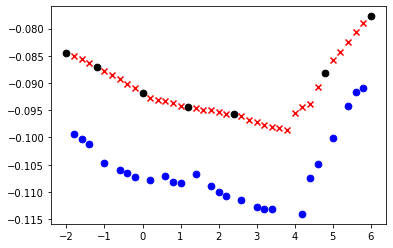

In [ ]:
x = [lf_x]
cm = [lf_cm]
plt.scatter(x,cm,edgecolors='b',facecolors='b',s=45,label="LF training points")
x = [lf_x,hf_x]
cm = [lf_cm,hf_cm]
plt.scatter(x[1],cm[1],edgecolors='k',facecolors='k',s=45,label="HF training points")
x = [hf_x_vali]
cm = [vali_cm]
plt.scatter(x[0],cm[0],marker='x',edgecolors='r',facecolors='r',label="HF validation points")


In [6]:
file_i_MF = open('./MyDrive/MyDrive/Colab Notebooks/data fusion/RHK_thesis/KFLOW_HK_i_MF.obj', 'rb') 
HK_i_MF = pickle.load(file_i_MF)
file_r_MF = open('./MyDrive/MyDrive/Colab Notebooks/data fusion/RHK_thesis/KFLOW_HK_r_MF.obj', 'rb') 
HK_r_MF = pickle.load(file_r_MF)
file_i_HF = open('./MyDrive/MyDrive/Colab Notebooks/data fusion/RHK_thesis/KFLOW_HK_i_HF.obj', 'rb') 
HK_i_HF = pickle.load(file_i_HF)
file_r_HF = open('./MyDrive/MyDrive/Colab Notebooks/data fusion/RHK_thesis/KFLOW_HK_r_HF.obj', 'rb') 
HK_r_HF = pickle.load(file_r_HF)

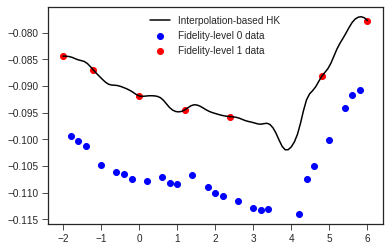

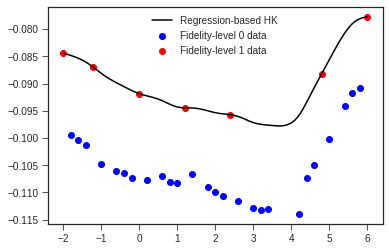

In [9]:
x = [lf_x, hf_x]
cm = [lf_cm, hf_cm]

pop = [100,100]
gen = [200,200]
x_test = np.linspace(AoA_start, AoA_end,101)
HK_i_MF = HK(x,cm,pop,gen,"i")
HK_i_MF.train()
HK_i_MF.plot_var(x_test,1)

HK_r_MF = HK(x,cm,pop,gen,"r")
HK_r_MF.train()
HK_r_MF.plot_var(x_test,1)

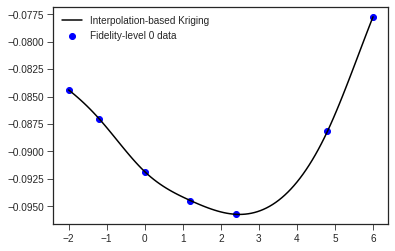

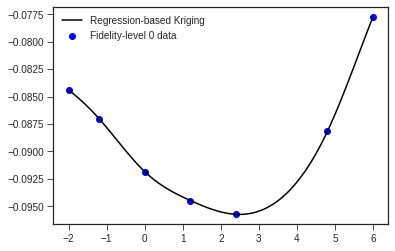

In [10]:
x = [hf_x]
cm = [hf_cm]

pop = [300,300]
gen = [200,200]
x_test = np.linspace(AoA_start, AoA_end,101)
HK_i_HF = HK(x,cm,pop,gen,"i")
HK_i_HF.train()
HK_i_HF.plot_var(x_test,0)

HK_r_HF = HK(x,cm,pop,gen,"r")
HK_r_HF.train()
HK_r_HF.plot_var(x_test,0)

In [ ]:
# file_i_MF = open('./MyDrive/MyDrive/Colab Notebooks/data fusion/RHK_thesis/KFLOW_HK_i_MF.obj', 'wb') 
# pickle.dump(HK_i_MF, file_i_MF)
# file_r_MF = open('./MyDrive/MyDrive/Colab Notebooks/data fusion/RHK_thesis/KFLOW_HK_r_MF.obj', 'wb') 
# pickle.dump(HK_r_MF, file_r_MF)
# file_i_HF = open('./MyDrive/MyDrive/Colab Notebooks/data fusion/RHK_thesis/KFLOW_HK_i_HF.obj', 'wb') 
# pickle.dump(HK_i_HF, file_i_HF)
# file_r_HF = open('./MyDrive/MyDrive/Colab Notebooks/data fusion/RHK_thesis/KFLOW_HK_r_HF.obj', 'wb') 
# pickle.dump(HK_r_HF, file_r_HF)


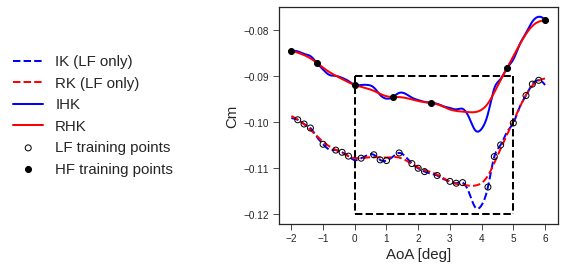

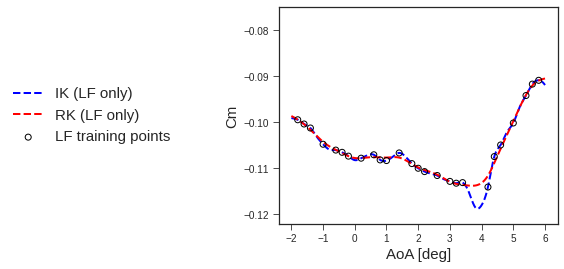

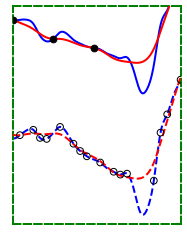

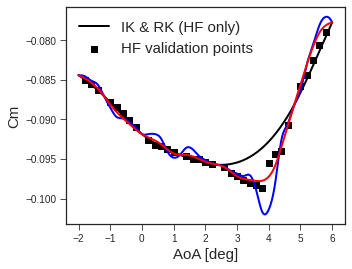

In [36]:
# x_test = np.linspace(-4,16.5,1001)
# print(np.min([np.min(hf_x_vali),np.min(hf_x)]))
x_test = np.linspace(np.min([np.min(lf_x),np.min(hf_x),np.min(hf_x_vali)]),np.max([np.max(lf_x),np.max(hf_x),np.max(hf_x_vali)]),1001)
y_pred_i_LF= HK_i_MF.pred_y_MSE(x_test, 0)[0]
y_pred_r_LF= HK_r_MF.pred_y_MSE(x_test, 0)[0]
y_pred_i_HF= HK_i_HF.pred_y_MSE(x_test, 0)[0]
y_pred_r_HF= HK_r_HF.pred_y_MSE(x_test, 0)[0]
y_pred_i_MF= HK_i_MF.pred_y_MSE(x_test, 1)[0]
y_pred_r_MF= HK_r_MF.pred_y_MSE(x_test, 1)[0]
# y_pred_i_MF_= HK_i_MF_.pred_y_MSE(x_test, 1)[0]
# y_pred_r_MF_= HK_r_MF_.pred_y_MSE(x_test, 1)[0]

left_bot = [0,-0.11]
right_top = [2,-0.09]
left_bot = [0,-0.12]
right_top = [5,-0.09]


############# LF only + MF 
x = [lf_x,hf_x]
cm = [lf_cm,hf_cm]

plt.figure(figsize=(5,4))
plt.scatter(x[0],cm[0],edgecolors='k',facecolors='none',label="LF training points",zorder = 4)
plt.scatter(x[1],cm[1],edgecolors='k',facecolors='k',label="HF training points",zorder = 5)
# plt.plot(x_test,y_pred_i_HF,'b-.',label = "IK (HF only)", lw=2,zorder = 0)
# plt.plot(x_test,y_pred_r_HF,'r-.',label = "RK (HF only)", lw=2,zorder = 1)
plt.plot(x_test,y_pred_i_LF,'b--',label = "IK (LF only)", lw=2,zorder = 0)
plt.plot(x_test,y_pred_r_LF,'r--',label = "RK (LF only)", lw=2,zorder = 1)
plt.plot(x_test,y_pred_i_MF,'b-',label = "IHK", lw=2,zorder = 2)
plt.plot(x_test,y_pred_r_MF,'r-',label = "RHK", lw=2,zorder = 3)
# plt.plot(x_test,y_pred_i_MF,'g-',label = "IHK (LF + shifted HF)", lw=2,zorder = 4)
# plt.plot(x_test,y_pred_r_MF-0.05,'g--',label = "RHK (LF + shifted HF)", lw=2,zorder = 5)
plt.legend(fontsize=15,loc='center left', bbox_to_anchor=(-1, 0.5),frameon=False)
plt.xlabel("AoA [deg]",fontsize=15)
plt.ylabel("Cm",fontsize=15)
plt.plot([left_bot[0], left_bot[0]], [right_top[1], left_bot[1]], '--',color='k', lw=2)
plt.plot([right_top[0], right_top[0]], [right_top[1], left_bot[1]], '--',color='k', lw=2)
plt.plot([left_bot[0], right_top[0]], [right_top[1], right_top[1]], '--',color='k', lw=2)
plt.plot([left_bot[0], right_top[0]], [left_bot[1], left_bot[1]], '--',color='k', lw=2)
axes = plt.gca()
xlim_ = (axes.get_xlim())
ylim_ = (axes.get_ylim())

plt.show()

############# LF only
x = [lf_x,hf_x]
cm = [lf_cm,hf_cm]
plt.figure(figsize=(5,4))
plt.scatter(x[0],cm[0],edgecolors='k',facecolors='none',label="LF training points",zorder = 4)
plt.plot(x_test,y_pred_i_LF,'b--',label = "IK (LF only)", lw=2,zorder = 0)
plt.plot(x_test,y_pred_r_LF,'r--',label = "RK (LF only)", lw=2,zorder = 1)
plt.legend(fontsize=15,loc='center left', bbox_to_anchor=(-1, 0.5),frameon=False)
plt.xlabel("AoA [deg]",fontsize=15)
plt.ylabel("Cm",fontsize=15)
plt.xlim(xlim_)
plt.ylim(ylim_)
plt.show()



############# IK IHK 비교위한 확대 그림
x = [lf_x,hf_x]
cm = [lf_cm,hf_cm]
# fig = plt.figure(figsize=(6.7,4))
fig = plt.figure(figsize=(3,4))
ax = fig.add_subplot()
for axxx in ['left','right','top','bottom']:
  ax.spines[axxx].set_color('g')
  ax.spines[axxx].set_linestyle('--')
  ax.spines[axxx].set_linewidth(2)

plt.scatter(x[0],cm[0],edgecolors='k',facecolors='none',s=45,label="LF training points",zorder = 6)
plt.scatter(x[1],cm[1],edgecolors='k',facecolors='k',s=45,label="HF training points",zorder = 7)
# plt.plot(x_test,y_pred_i_HF,'b-.',label = "IK (HF only)", lw=2,zorder = 0)
# plt.plot(x_test,y_pred_r_HF,'r-.',label = "RK (HF only)", lw=2,zorder = 1)
plt.plot(x_test,y_pred_i_LF,'b--',label = "IK (LF only)", lw=2,zorder = 2)
plt.plot(x_test,y_pred_i_MF,'b-',label = "IHK (LF + HF)", lw=2,zorder = 3)
plt.plot(x_test,y_pred_r_LF,'r--',label = "RK (LF only)", lw=2,zorder = 4)
plt.plot(x_test,y_pred_r_MF,'r-',label = "RHK (LF + HF)", lw=2,zorder = 5)

ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
# plt.legend(fontsize=15,loc='center left', bbox_to_anchor=(1, 0.5))
# plt.legend(fontsize=15)
plt.xlim(left_bot[0],right_top[0])
plt.ylim(left_bot[1],right_top[1])
plt.show()

############# HF validation
x = [hf_x_vali]
cm = [vali_cm]

plt.figure(figsize=(5,4))
plt.scatter(x[0],cm[0],marker='s',edgecolors='k',facecolors='k',label="HF validation points",zorder = 2)
# plt.plot(x_test,y_pred_i_HF,'b-.',label = "IK (HF only)", lw=2,zorder = 0)
# plt.plot(x_test,y_pred_r_HF,'r-.',label = "RK (HF only)", lw=2,zorder = 1)
# plt.plot(x_test,y_pred_i_MF,'b-',label = "IHK (LF + HF)", lw=2,zorder = 2)
# plt.plot(x_test,y_pred_r_MF,'r-',label = "RHK (LF + HF)", lw=2,zorder = 3)
plt.plot(x_test,y_pred_i_HF,'k-', label="IK & RK (HF only)", lw=2,zorder = 0)
# plt.plot(x_test,y_pred_r_HF,'r-.', lw=2,zorder = 1)
plt.plot(x_test,y_pred_i_MF,'b-', lw=2,zorder = 2)
plt.plot(x_test,y_pred_r_MF,'r-',lw=2,zorder = 3)

plt.legend(fontsize=15, frameon=False)
plt.xlabel("AoA [deg]",fontsize=15)
plt.ylabel("Cm",fontsize=15)
# plt.xlim(xlim_)
# plt.ylim(ylim_)

plt.show()



R_sq of IK: 0.9335
R_sq of RK: 0.9335
R_sq of IHK: 0.9390
R_sq of RHK: 0.9866
rmse of IK: 0.0016
rmse of RK: 0.0016
rmse of IHK: 0.0016
rmse of RHK: 0.0007
MAE of IK: 0.0010
MAE of RK: 0.0010
MAE of IHK: 0.0011
MAE of RHK: 0.0005
[-0.07159325987958931]
[-0.071590360085872]
[-0.10463803150671491, 0.8574823541880424]
[-0.10140464308562537, 0.8598478358951566]


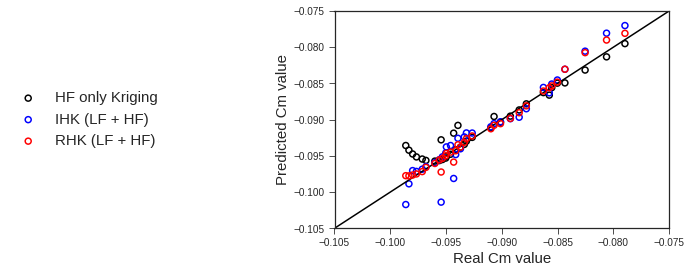

In [38]:
y_pred_vali_i = HK_i_MF.pred_y_MSE(hf_x_vali,1)[0]
y_pred_vali_r = HK_r_MF.pred_y_MSE(hf_x_vali,1)[0]
y_pred_vali_i_HF = HK_i_HF.pred_y_MSE(hf_x_vali,0)[0]
y_pred_vali_r_HF = HK_r_HF.pred_y_MSE(hf_x_vali,0)[0]

r_squared_IK = HK_i_HF.Rsq(hf_x_vali, vali_cm, 0)
r_squared_RK = HK_r_HF.Rsq(hf_x_vali, vali_cm, 0)
r_squared_IHK = HK_i_MF.Rsq(hf_x_vali, vali_cm, 1)
r_squared_RHK = HK_r_MF.Rsq(hf_x_vali, vali_cm, 1)

print(f"R_sq of IK: {r_squared_IK:.4f}")
print(f"R_sq of RK: {r_squared_RK:.4f}")
print(f"R_sq of IHK: {r_squared_IHK:.4f}")
print(f"R_sq of RHK: {r_squared_RHK:.4f}")

rmse_IK = HK_i_HF.RMSE(hf_x_vali, vali_cm, 0)
rmse_RK = HK_r_HF.RMSE(hf_x_vali, vali_cm, 0)
rmse_IHK = HK_i_MF.RMSE(hf_x_vali, vali_cm, 1)
rmse_RHK = HK_r_MF.RMSE(hf_x_vali, vali_cm, 1)

print(f"rmse of IK: {rmse_IK:.4f}")
print(f"rmse of RK: {rmse_RK:.4f}")
print(f"rmse of IHK: {rmse_IHK:.4f}")
print(f"rmse of RHK: {rmse_RHK:.4f}")

MAE_IK = HK_i_HF.MAE(hf_x_vali, vali_cm, 0)
MAE_RK = HK_r_HF.MAE(hf_x_vali, vali_cm, 0)
MAE_IHK = HK_i_MF.MAE(hf_x_vali, vali_cm, 1)
MAE_RHK = HK_r_MF.MAE(hf_x_vali, vali_cm, 1)

print(f"MAE of IK: {MAE_IK:.4f}")
print(f"MAE of RK: {MAE_RK:.4f}")
print(f"MAE of IHK: {MAE_IHK:.4f}")
print(f"MAE of RHK: {MAE_RHK:.4f}")

print(HK_i_HF.total_beta)
print(HK_r_HF.total_beta)
print(HK_i_MF.total_beta)
print(HK_r_MF.total_beta)
# limit = np.array([np.min([y_pred_vali_i, y_pred_vali_r, vali_cm]),np.max([y_pred_vali_i, y_pred_vali_r, vali_cm])])
limit = np.array([-0.105,-0.075])
plt.figure(figsize=(6,4))
plt.xlim([-0.105,-0.075])
plt.ylim([-0.105,-0.075])
plt.plot(limit,limit,c='k')
# plt.scatter(vali_cm,y_pred_vali_i_HF, edgecolors='k',facecolors='none', linewidths=1.5,label = f'IK & RK (HF only, R\N{SUPERSCRIPT TWO}={r_squared_IK:.3f})',zorder=0)
plt.scatter(vali_cm,y_pred_vali_i_HF, edgecolors='k',facecolors='none', linewidths=1.5,label = f'HF only Kriging',zorder=0)


plt.xlabel("Real Cm value", fontsize = 15)
plt.ylabel("Predicted Cm value", fontsize = 15)
plt.scatter(vali_cm,y_pred_vali_i, edgecolors='b',facecolors='none', linewidths=1.5,label = f'IHK (LF + HF)',zorder=2)
plt.scatter(vali_cm,y_pred_vali_r, edgecolors='r',facecolors='none', linewidths=1.5, label = f'RHK (LF + HF)',zorder=3)
# plt.scatter(vali_cm,y_pred_vali_i, edgecolors='b',facecolors='none', linewidths=1.5,label = f'IHK (LF + HF, R\N{SUPERSCRIPT TWO}={r_squared_IHK:.3f})',zorder=2)
# plt.scatter(vali_cm,y_pred_vali_r, edgecolors='r',facecolors='none', linewidths=1.5, label = f'RHK (LF + HF, R\N{SUPERSCRIPT TWO}={r_squared_RHK:.3f})',zorder=3)
plt.xlabel("Real Cm value", fontsize = 15)
plt.ylabel("Predicted Cm value", fontsize = 15)
plt.legend(fontsize=15,loc='center left', bbox_to_anchor=(-1, 0.5),frameon=False)
plt.show()


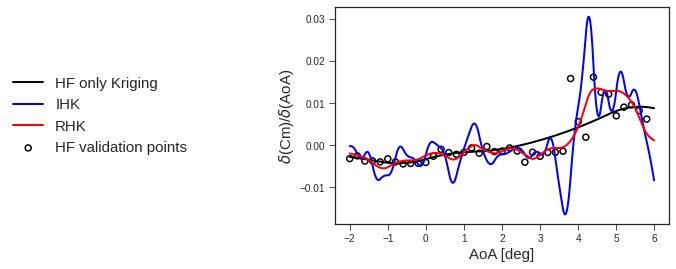

In [34]:
def cal_grad(x,y):
  grad = np.zeros(y.shape[0]-1)
  for enu in range(y.shape[0]-1):
    grad[enu] = ( y[enu+1] - y[enu] ) / ( x[enu+1] - x[enu] )
  return grad
x_test = np.linspace(np.min([np.min(lf_x),np.min(hf_x),np.min(hf_x_vali)]),np.max([np.max(lf_x),np.max(hf_x),np.max(hf_x_vali)]),1001)
y_pred_i_LF= HK_i_MF.pred_y_MSE(x_test, 0)[0]
y_pred_r_LF= HK_r_MF.pred_y_MSE(x_test, 0)[0]
y_pred_i_HF= HK_i_HF.pred_y_MSE(x_test, 0)[0]
y_pred_r_HF= HK_r_HF.pred_y_MSE(x_test, 0)[0]
y_pred_i_MF= HK_i_MF.pred_y_MSE(x_test, 1)[0]
y_pred_r_MF= HK_r_MF.pred_y_MSE(x_test, 1)[0]
hf=np.load("./MyDrive/MyDrive/Colab Notebooks/data fusion/RHK_thesis/kflow_hf.npy")
AoA_start, AoA_end = -2, 6
x = np.linspace(AoA_start, AoA_end,41)
# print(hf)
grad_hf = cal_grad(x,hf[:,2])
grad_HF_only = cal_grad(x_test,y_pred_i_HF)
grad_i_MF = cal_grad(x_test,y_pred_i_MF)
grad_r_MF = cal_grad(x_test,y_pred_r_MF)

# plt.scatter(x[:-1],grad_hf,marker='s',edgecolors='k',facecolors='k',label="HF validation points",zorder = 0)
plt.scatter(x[:-1],grad_hf,edgecolors='k',facecolors='none', linewidths=1.5,label="HF validation points",zorder = 0)
plt.plot(x_test[:-1],grad_HF_only,'k',lw=2,label="HF only Kriging",zorder = 1)
plt.plot(x_test[:-1],grad_i_MF,'b',lw=2,label="IHK",zorder = 2)
plt.plot(x_test[:-1],grad_r_MF,'r',lw=2,label="RHK",zorder = 3)
# plt.scatter(x[0],cm[0],marker='s',edgecolors='k',facecolors='k',label="HF validation points",zorder = 2)
plt.legend(fontsize=15, frameon=False)
plt.xlabel("AoA [deg]",fontsize=15)
plt.ylabel("$ \delta $(Cm)/$ \delta $(AoA)",fontsize=15)
plt.legend(fontsize=15,loc='center left', bbox_to_anchor=(-1, 0.5),frameon=False)
plt.show()
# y_pred_vali_i = HK_i_MF.pred_y_MSE(hf_x_vali,1)[0]
# y_pred_vali_r = HK_r_MF.pred_y_MSE(hf_x_vali,1)[0]

10.749231348350726
8.299692539340287


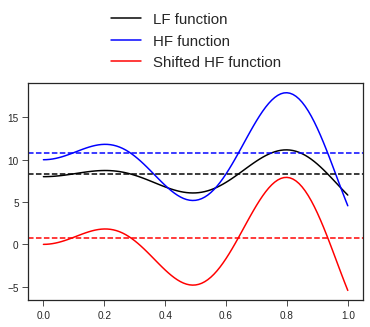

In [ ]:
def test_func(a,x):
  y = a*x*np.sin(x*10)+ 10
  return y
x_test__ = np.linspace(0,1,101)
print(np.mean(test_func(10,x_test__)))
print(np.mean(test_func(4,x_test__))-2)
plt.plot(x_test__,test_func(4,x_test__)-2,'k',label='LF function')
# plt.plot(x_test__,test_func(2,x_test__))
plt.plot(x_test__,test_func(10,x_test__),'b',label='HF function')
plt.plot(x_test__,test_func(10,x_test__)-10,'r',label='Shifted HF function')
plt.axhline(y=8.299692539340287, color='k', linestyle='--')
plt.axhline(y=10.749231348350726, color='b', linestyle='--')
plt.axhline(y=0.749, color='r', linestyle='--')
plt.legend(fontsize=15,loc='lower center', bbox_to_anchor=(0.5, 1),frameon=False)
plt.show()

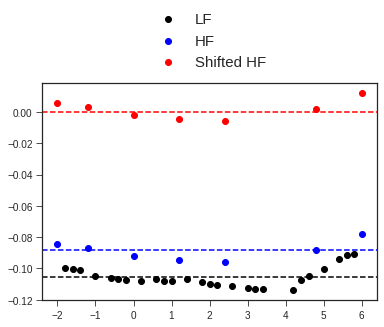

In [ ]:

plt.scatter(lf_x,lf_cm,edgecolors='k',facecolors='k',label="LF")
plt.scatter(hf_x,hf_cm,edgecolors='b',facecolors='b',label="HF")
# plt.scatter(hf_x,hf_cm+0.09,edgecolors='r',facecolors='r',label="Shifted HF")
plt.legend(fontsize=15,loc='lower center', bbox_to_anchor=(0.5, 1),frameon=False)
plt.axhline(y=-0.10564657692307693, color='k', linestyle='--')
plt.axhline(y=-0.08848442857142857, color='b', linestyle='--')
plt.axhline(y=0., color='r', linestyle='--')
plt.show()
# print(lf_x.shape, hf_x.shape, hf_x_vali.shape)
# print(np.sort(lf_x[:,0]))
# print(np.sort(hf_x[:,0]))


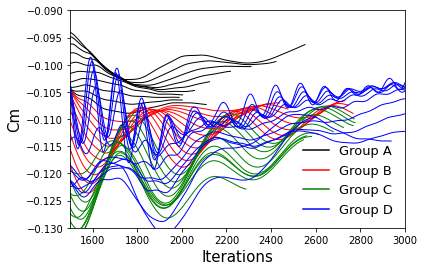

In [ ]:
l2_lf = {}

for i in range(1,42):
  with open(f'./MyDrive/MyDrive/Colab Notebooks/data fusion/RHK_thesis/l2norm_lf/{i}_l2.dat', 'r') as file_:
    file_.readline()
    f_read = file_.readlines()
    temp_l2 = []
    for x in f_read:
      x = x.strip().split()
      temp_l2.append([x[0],x[8]])
    temp_l2 = np.array(temp_l2, dtype = np.float)
    l2_lf[f'{i}'] = temp_l2

for idx,i in enumerate(l2_lf.values()):
  if 0 <= idx <= 9:
    plt.plot(i[:,0],i[:,1],'k',lw=1)
  elif 10 <= idx <= 19:
    plt.plot(i[:,0],i[:,1],'r',lw=1)
  elif 20 <= idx <= 29:
    plt.plot(i[:,0],i[:,1],'g',lw=1)
  elif 30 <= idx <= 40:
    plt.plot(i[:,0],i[:,1],'b',lw=1)
  
# plt.plot([0,0],[99,99],'k',label='AoA -2\N{DEGREE SIGN} ~ 0\N{DEGREE SIGN}')
# plt.plot([0,0],[99,99],'r',label='AoA 0\N{DEGREE SIGN} ~ 2\N{DEGREE SIGN}')
# plt.plot([0,0],[99,99],'g',label='AoA 2\N{DEGREE SIGN} ~ 4\N{DEGREE SIGN}')
# plt.plot([0,0],[99,99],'b',label='AoA 4\N{DEGREE SIGN} ~ 6\N{DEGREE SIGN}')
plt.plot([0,0],[99,99],'k',label='Group A')
plt.plot([0,0],[99,99],'r',label='Group B')
plt.plot([0,0],[99,99],'g',label='Group C')
plt.plot([0,0],[99,99],'b',label='Group D')
plt.xlim(1500,3000)
plt.ylim(-0.13,-0.09)
plt.xlabel("Iterations", fontsize = 15)
plt.ylabel("Cm", fontsize = 15)
plt.legend(fontsize = 13,frameon=False)
plt.show()


[]

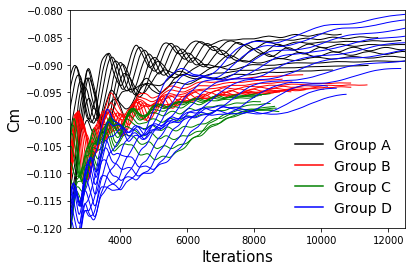

In [ ]:
l2_hf = {}

for i in range(1,42):
  with open(f'./MyDrive/MyDrive/Colab Notebooks/data fusion/RHK_thesis/l2norm_hf/{i}_l2.dat', 'r') as file_:
    file_.readline()
    f_read = file_.readlines()
    temp_l2 = []
    for x in f_read:
      x = x.strip().split()
      temp_l2.append([x[0],x[8]])
    temp_l2 = np.array(temp_l2, dtype = np.float)
    l2_hf[f'{i}'] = temp_l2

for idx,i in enumerate(l2_hf.values()):
  if 0 <= idx <= 9:
    plt.plot(i[:,0],i[:,1],'k',lw=1)
  elif 10 <= idx <= 19:
    plt.plot(i[:,0],i[:,1],'r',lw=1)
  elif 20 <= idx <= 29:
    plt.plot(i[:,0],i[:,1],'g',lw=1)
  elif 30 <= idx <= 40:
    plt.plot(i[:,0],i[:,1],'b',lw=1)

plt.plot([0,0],[99,99],'k',label='Group A')
plt.plot([0,0],[99,99],'r',label='Group B')
plt.plot([0,0],[99,99],'g',label='Group C')
plt.plot([0,0],[99,99],'b',label='Group D')
plt.xlim(2500,12500)
plt.ylim(-0.12,-0.08)
plt.xlabel("Iterations", fontsize = 15)
plt.ylabel("Cm", fontsize = 15)
plt.legend(fontsize = 14,frameon=False)
plt.plot()


In [ ]:
# @title 데이터에 noise가 섞여있는 경우

def cubic_func (x) :

  return x**2
N_pts = 8

x_test = np.array([-1,-0.5,-0.1,0,0.1,0.15,0.5,1])
# y_test_n = np.array([1.20292616, 0.39984616, 0.04874587, -0.12883884, 0.03620817, 0.00193524, 0.10518517, 0.92998561] )

  

x = np.linspace(-1,1,101)
y = cubic_func(x)
y_test_n = cubic_func(x_test)
for enu,i in enumerate(y_test_n):
  y_test_n[enu] += np.random.normal(0,0.05)
x_HK = []
x_HK.append(np.array([[i] for i in x_test]))
# y_HK = [y_test]
y_HK_n = [y_test_n]
pop = [100, 100]
gen = [200,200]

HK_i = HK(x_HK,y_HK_n,pop,gen,"i")
HK_i.train_HK("y")

HK_r = HK(x_HK,y_HK_n,pop,gen,"r")
HK_r.train_HK("y")

plt.style.use('seaborn-ticks')
    


#########  Level 0 starts  #########
   Generation = 43
   Optimal theta = [1.52905634]
   Optimal likelihood = 8.988881
   Optimal R's condition number = 86.404772
   Level 0 finishes with time 4.360501[s]
#########  Total time = 4.361393[s]  #########

#########  Level 0 starts  #########
   Generation = 56
   Optimal theta = [0.14930921]
   Optimal nugget = 3.460956E-03
   Optimal likelihood = 11.397749
   Optimal R's condition number = 2002.694373
   Level 0 finishes with time 5.490385[s]
#########  Total time = 5.490871[s]  #########



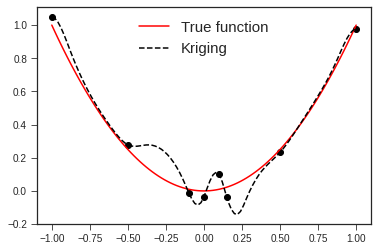

In [ ]:
y_pred_i= HK_i.pred_y_MSE(x, 0)
y_pred_r= HK_r.pred_y_MSE(x, 0)
plt.scatter(x_test,y_HK_n,c='k')
plt.plot(x,cubic_func(x),'r-',label="True function")
plt.plot(x,y_pred_i[0],'k--',label = "Kriging")
# plt.plot(x,y_pred_r[0],'k-',label = "RK")
plt.legend(fontsize=15)
# plt.xlabel("x",fontsize=13)
# plt.ylabel("y",fontsize=13)
plt.show()

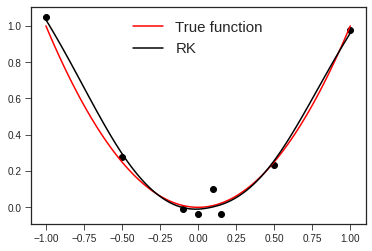

In [ ]:
y_pred_i= HK_i.pred_y_MSE(x, 0)
y_pred_r= HK_r.pred_y_MSE(x, 0)
plt.scatter(x_test,y_HK_n,c='k')
plt.plot(x,cubic_func(x),'r-',label="True function")
# plt.plot(x,y_pred_i[0],'k--',label = "IK")
plt.plot(x,y_pred_r[0],'k-',label = "RK")
plt.legend(fontsize=15)
# plt.xlabel("x",fontsize=13)
# plt.ylabel("y",fontsize=13)
plt.show()

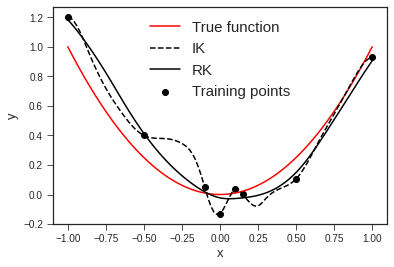

In [ ]:
y_pred_i= HK_i.pred_y_MSE(x, 0)
y_pred_r= HK_r.pred_y_MSE(x, 0)
plt.scatter(x_test,y_HK_n,c='k',label="Training points")
plt.plot(x,cubic_func(x),'r-',label="True function")
plt.plot(x,y_pred_i[0],'k--',label = "IK")
plt.plot(x,y_pred_r[0],'k-',label = "RK")
plt.legend(fontsize=15)
plt.xlabel("x",fontsize=13)
plt.ylabel("y",fontsize=13)
plt.show()

In [ ]:
def hhg_level_2(x): # HF
  y = (6*x.flatten()-2)**2*np.sin(12*x.flatten()-4)
  return y.flatten()
def hhg_level_1(x): # MF
  y = 0.5 * hhg_level_2(x.flatten()) + 10 * (x.flatten() - 0.5 ) -5 
  return y.flatten()
# def hhg_level_1_lin(x):
#   y = 0.5 * hhg_level_2(x.flatten()) -5 
#   return y.flatten()
def hhg_level_0(x): # LF
  y = 3*(0.2 * hhg_level_1(x.flatten()) + 5 * np.sin(x.flatten()) )
  return y.flatten()



# x=[]
# asdf = np.linspace(0,1,21)
# asdf=np.append(asdf,0.725)
# asdf=np.append(asdf,0.775) # LF에서 최적해인 x=0.750 근처에 점이 몰려있는 것을 과장위해
# d = [[temp] for temp in asdf]
# x.append( np.array(d) ) # LF
# x.append( np.array([[0],[0.15],[0.3],[0.45],[0.6],[0.75],[0.9],[1]]) ) # MF
# x.append(np.array([[0],[0.4],[0.6],[1]])) # HF

# y=[]
# y.append( hhg_level_0(x[0]) )
# y.append( hhg_level_1(x[1]) )
# y.append( hhg_level_2(x[2]) )
# for enu,xxx in enumerate(y[0]):
#   y[0][enu] += np.random.normal(0,0.3)
# print(x)
# print(y)

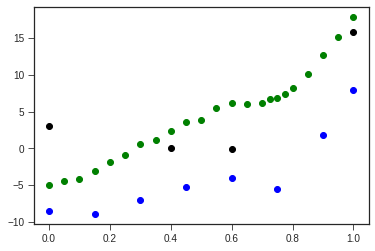

In [ ]:
plt.scatter(x[0],y[0],c='g',label="LF sampling points")
plt.scatter(x[1],y[1],c='b',label="MF sampling points")
plt.scatter(x[2],y[2],c='k',label="HF sampling points")

[array([[0.   ],
       [0.05 ],
       [0.1  ],
       [0.15 ],
       [0.2  ],
       [0.25 ],
       [0.3  ],
       [0.35 ],
       [0.4  ],
       [0.45 ],
       [0.5  ],
       [0.55 ],
       [0.6  ],
       [0.65 ],
       [0.7  ],
       [0.75 ],
       [0.8  ],
       [0.85 ],
       [0.9  ],
       [0.95 ],
       [1.   ],
       [0.725],
       [0.775]]), array([[0.  ],
       [0.15],
       [0.3 ],
       [0.45],
       [0.6 ],
       [0.75],
       [0.9 ],
       [1.  ]]), array([[0. ],
       [0.4],
       [0.6],
       [1. ]])] [array([-5.03282141, -4.42323075, -4.13802121, -3.0227405 , -1.81846438,
       -0.92156957,  0.65333693,  1.18764855,  2.3744443 ,  3.6340209 ,
        3.79034185,  5.51192982,  6.20306483,  5.968832  ,  6.20152874,
        6.81362126,  8.15600694, 10.08655896, 12.68281296, 15.13773614,
       17.90662391,  6.77479274,  7.35858708]), array([-8.48639501, -8.98914032, -7.00778837, -5.25856482, -4.0747189 ,
       -5.49663836,  1.85597517,  7.9148

IndexError: ignored

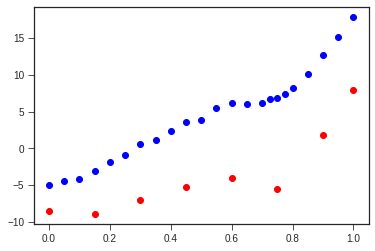

In [ ]:
for i in range(1):
  x = [np.array([[0.   ],
       [0.05 ],
       [0.1  ],
       [0.15 ],
       [0.2  ],
       [0.25 ],
       [0.3  ],
       [0.35 ],
       [0.4  ],
       [0.45 ],
       [0.5  ],
       [0.55 ],
       [0.6  ],
       [0.65 ],
       [0.7  ],
       [0.75 ],
       [0.8  ],
       [0.85 ],
       [0.9  ],
       [0.95 ],
       [1.   ],
       [0.725],
       [0.775]]), np.array([[0.  ],
       [0.15],
       [0.3 ],
       [0.45],
       [0.6 ],
       [0.75],
       [0.9 ],
       [1.  ]]), np.array([[0. ],
       [0.4],
       [0.6],
       [1. ]])]
  y = [np.array([-5.03282141, -4.42323075, -4.13802121, -3.0227405 , -1.81846438,
       -0.92156957,  0.65333693,  1.18764855,  2.3744443 ,  3.6340209 ,
        3.79034185,  5.51192982,  6.20306483,  5.968832  ,  6.20152874,
        6.81362126,  8.15600694, 10.08655896, 12.68281296, 15.13773614,
       17.90662391,  6.77479274,  7.35858708]), np.array([-8.48639501, -8.98914032, -7.00778837, -5.25856482, -4.0747189 ,
       -5.49663836,  1.85597517,  7.91486597]), np.array([ 3.02720998,  0.11477697, -0.14943781, 15.82973195])]

print(x,y)
pop = [100,100,100]
gen = [200,200,200]
x_test = np.linspace(0,1,101)
HK_i = HK(x,y,pop,gen,"i")
HK_i.train_HK("y")
HK_i.plot_var(x_test,2,"none")
HK_r = HK(x,y,pop,gen,"r")
HK_r.train_HK("y")
HK_r.plot_var(x_test,2,"none")



#########  Level 0 starts  #########
   Generation = 42
   Optimal theta = [0.92117295]
   Optimal likelihood = 5.408022
   Optimal R's condition number = 95047.406755
   Level 0 finishes with time 24.396388[s]
#########  Level 1 starts  #########
   Generation = 41
   Optimal theta = [0.12788464]
   Optimal likelihood = -2.450200
   Optimal R's condition number = 129227.923550
   Level 1 finishes with time 4.197447[s]
#########  Level 2 starts  #########
   Generation = 41
   Optimal theta = [0.14299071]
   Optimal likelihood = -5.413059
   Optimal R's condition number = 3776.239700
   Level 2 finishes with time 2.138534[s]
#########  Total time = 30.733028[s]  #########



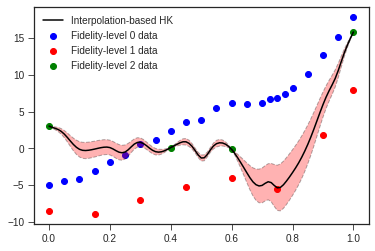

In [ ]:
HK_i = HK(x,y,pop,gen,"i")
HK_i.train_HK("y")
HK_i.plot_var(x_test,2,"none")

#########  Level 0 starts  #########
   Generation = 54
   Optimal theta = [0.41467119]
   Optimal nugget = 3.022891E-04
   Optimal likelihood = 7.067120
   Optimal R's condition number = 56677.940881
   Level 0 finishes with time 32.279914[s]
#########  Level 1 starts  #########
   Generation = 47
   Optimal theta = [0.09505072]
   Optimal nugget = 2.389820E-04
   Optimal likelihood = -2.381488
   Optimal R's condition number = 29584.481229
   Level 1 finishes with time 4.598801[s]
#########  Level 2 starts  #########
   Generation = 52
   Optimal theta = [0.04498907]
   Optimal nugget = 1.003921E-09
   Optimal likelihood = -4.856370
   Optimal R's condition number = 120460.968558
   Level 2 finishes with time 2.494745[s]
#########  Total time = 39.377416[s]  #########



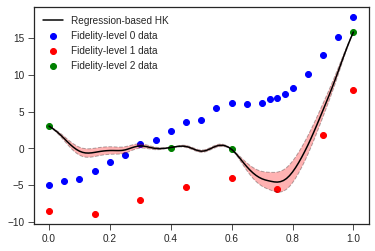

In [ ]:
HK_r = HK(x,y,pop,gen,"r")
HK_r.train_HK("y")
HK_r.plot_var(x_test,2,"none")

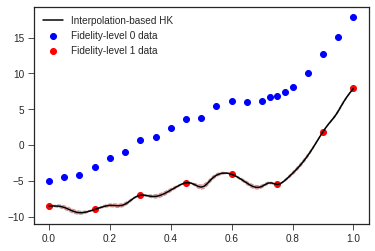

In [ ]:
HK_i.plot_var(x_test,1,"none")

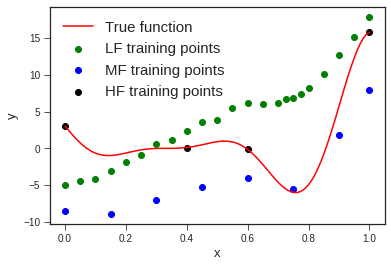

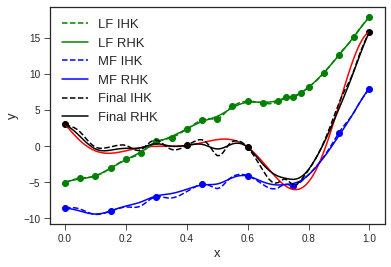

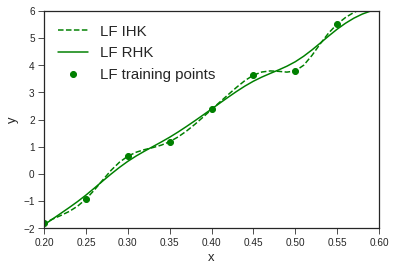

In [ ]:
plt.style.use('seaborn-ticks')

x_test = np.linspace(0,1,101)
y_pred_i= HK_i.pred_y_MSE(x_test, 2)
y_pred_r= HK_r.pred_y_MSE(x_test, 2)
plt.plot(x_test,hhg_level_2(x_test),'r-',label="True function")
plt.scatter(x[0],y[0],c='g',label="LF training points")
plt.scatter(x[1],y[1],c='b',label="MF training points")
plt.scatter(x[2],y[2],c='k',label="HF training points")
plt.xlabel("x",fontsize=13)
plt.ylabel("y",fontsize=13)
plt.legend(fontsize=15)
plt.show()

plt.plot(x_test,hhg_level_2(x_test),'r-')
plt.scatter(x[0],y[0],c='g')
plt.scatter(x[1],y[1],c='b')
plt.scatter(x[2],y[2],c='k')
y_pred_i= HK_i.pred_y_MSE(x_test, 0)
y_pred_r= HK_r.pred_y_MSE(x_test, 0)
plt.plot(x_test,y_pred_i[0],'g--',label = "LF IHK")
plt.plot(x_test,y_pred_r[0],'g-',label = "LF RHK")
y_pred_i= HK_i.pred_y_MSE(x_test, 1)
y_pred_r= HK_r.pred_y_MSE(x_test, 1)
plt.plot(x_test,y_pred_i[0],'b--',label = "MF IHK")
plt.plot(x_test,y_pred_r[0],'b-',label = "MF RHK")
y_pred_i= HK_i.pred_y_MSE(x_test, 2)
y_pred_r= HK_r.pred_y_MSE(x_test, 2)
plt.plot(x_test,y_pred_i[0],'k--',label = "Final IHK")
plt.plot(x_test,y_pred_r[0],'k-',label = "Final RHK")

plt.xlabel("x",fontsize=13)
plt.ylabel("y",fontsize=13)
plt.legend(fontsize=13)
plt.show()

y_pred_i= HK_i.pred_y_MSE(x_test, 0)
y_pred_r= HK_r.pred_y_MSE(x_test, 0)
plt.scatter(x[0],y[0],c='g',label="LF training points")
plt.plot(x_test,y_pred_i[0],'g--',label = "LF IHK")
plt.plot(x_test,y_pred_r[0],'g-',label = "LF RHK")
plt.xlabel("x",fontsize=13)
plt.ylabel("y",fontsize=13)
plt.legend(fontsize=15)
plt.xlim(0.2,0.6)
plt.ylim(-2,6)
plt.show()